In [58]:
import torch
import torch.nn.functional as F

import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

from tqdm import tqdm

In [2]:
ds = TUDataset("/tmp/PROTEINS", "PROTEINS")
ds.num_features, ds.num_classes, len(ds)

(3, 2, 1113)

In [3]:
ds = ds.shuffle()
break1 = int(len(ds) * 0.8)
break2 = int(len(ds) * 0.9)
training_data = ds[:break1]
validation_data = ds[break1:break2]
test_data = ds[break2:]
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

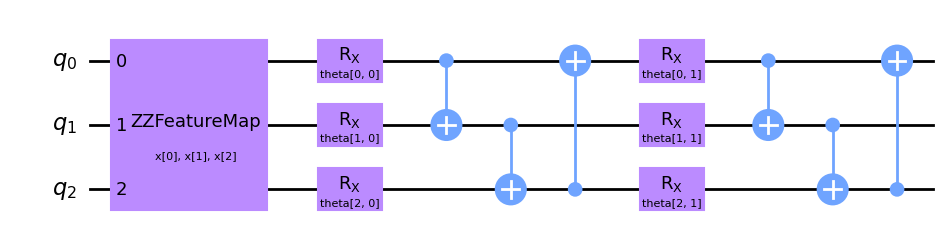

In [46]:
encoding = ZZFeatureMap(ds.num_features, reps=2)
qc = QuantumCircuit(ds.num_features)
qc.compose(encoding, inplace=True)

weights = [[Parameter(f"theta[{i}, {j}]") for i in range(ds.num_features)] for j in range(2)]

for j in range(2):
    for i in range(ds.num_features):
        qc.rx(weights[j][i], i)
    
    for i in range(ds.num_features):
        qc.cx(i, (i + 1) % ds.num_features)

qc.draw(output="mpl", style="clifford")

In [59]:
qnn = SamplerQNN(
    circuit=qc,
    input_params=encoding.parameters,
    weight_params=weights[0] + weights[1],
)
embedder = TorchConnector(qnn)

In [67]:
class QFE_GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.qfe = embedder

        self.gcns = torch.nn.ParameterList([
            GCNConv(2**in_features, 16),
            GCNConv(16, 16),
            GCNConv(16, out_features),
        ])

        # self.gcn1 = GCNConv(in_features, 16)
        # self.gcn2 = GCNConv(16, out_features)
    
    def forward(self, data):
        x = data.x
        x = self.qfe(x.to(device="cpu")).to(device=x.device)

        for gcn in self.gcns:
            x = gcn(x, data.edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        # x = self.gcn1(x, data.edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.gcn2(x, data.edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        
        out = torch.zeros(data.num_graphs, 2, device=x.device)

        for i in range(data.num_graphs):
            out[i] = x[data.batch == i].mean(dim=0)
        
        out = F.log_softmax(out, dim=1)

        return out

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QFE_GCN(3, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []

model.train()
for epoch in range(10):
    epoch_losses = []
    print(f"Epoch {epoch}")
    for batch in tqdm(training_loader):
        optimizer.zero_grad()
        out = model(batch.to(device))
        # print(out, batch.y)
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        epoch_losses.append(loss.detach().cpu())
        optimizer.step()
    losses.append(epoch_losses)

Epoch 0


  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [42:41<00:00, 91.49s/it]  


Epoch 1


100%|██████████| 28/28 [40:50<00:00, 87.52s/it]


Epoch 2


100%|██████████| 28/28 [41:12<00:00, 88.31s/it]


Epoch 3


100%|██████████| 28/28 [40:45<00:00, 87.35s/it]


Epoch 4


100%|██████████| 28/28 [40:58<00:00, 87.80s/it] 


Epoch 5


100%|██████████| 28/28 [40:44<00:00, 87.31s/it]


Epoch 6


100%|██████████| 28/28 [40:38<00:00, 87.11s/it] 


Epoch 7


100%|██████████| 28/28 [40:30<00:00, 86.80s/it]


Epoch 8


100%|██████████| 28/28 [40:39<00:00, 87.13s/it]


Epoch 9


100%|██████████| 28/28 [40:28<00:00, 86.74s/it] 


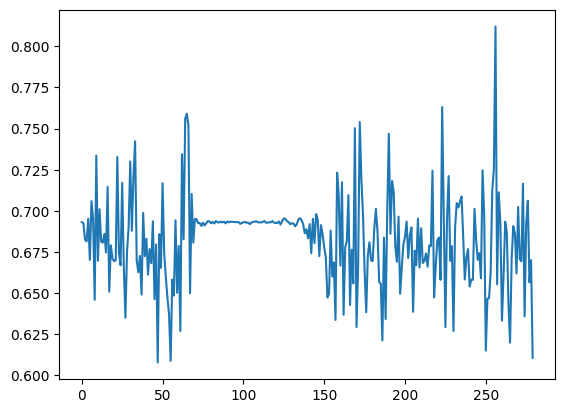

In [70]:
import matplotlib.pyplot as plt
plt.plot(np.array(losses).flatten())

In [71]:
model.eval()
correct = 0
total = 0
for batch in test_loader:
    out = model(batch.to(device))
    print(out, batch.y)
    print(out.argmax(dim=1))
    correct += sum(out.argmax(dim=1) == batch.y)
    total += len(batch.y)
print(f"Accuracy: {correct/total}")

tensor([[-0.5290, -0.8897],
        [-0.5252, -0.8951],
        [-0.5281, -0.8909],
        [-0.5321, -0.8852],
        [-0.5257, -0.8943],
        [-0.5389, -0.8756],
        [-0.5407, -0.8731],
        [-0.5271, -0.8923],
        [-0.5282, -0.8908],
        [-0.5263, -0.8935],
        [-0.5187, -0.9047],
        [-0.5318, -0.8857],
        [-0.5323, -0.8849],
        [-0.5322, -0.8851],
        [-0.5285, -0.8903],
        [-0.5228, -0.8986],
        [-0.5334, -0.8833],
        [-0.5337, -0.8830],
        [-0.5362, -0.8794],
        [-0.5279, -0.8912],
        [-0.5292, -0.8893],
        [-0.5265, -0.8933],
        [-0.5264, -0.8933],
        [-0.5194, -0.9035],
        [-0.5265, -0.8932],
        [-0.5287, -0.8901],
        [-0.5314, -0.8861],
        [-0.5345, -0.8818],
        [-0.5209, -0.9014],
        [-0.5362, -0.8793],
        [-0.5182, -0.9053],
        [-0.5374, -0.8778]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>) tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,